<a href="https://colab.research.google.com/github/SciMathist/QSiM-Quantum-Simulator/blob/main/qsim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

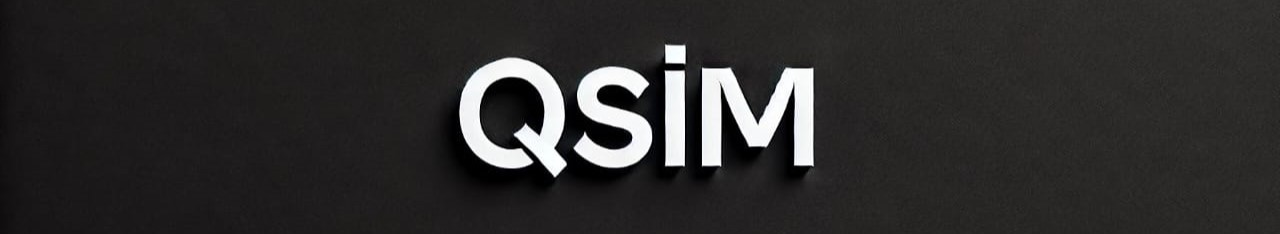


---


# **Quantum Circuit Simulator**

This project is maintained by **Saptadip Saha**.

[LinkedIn](https://www.linkedin.com/in/saptadip-saha-exploreme) | [GitHub](https://github.com/SciMathist/QSiM-Quantum-Simulator/)

### Setting up dependencies

In [ ]:
%pip install numpy matplotlib  # Install if the dependencies are not pre-installed.

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

**Note:** We follow left ordering, i.e. the LSB is on the leftmost position.

## Matrix based circuit simulator class `QuantumCircuit`

In [140]:
class QuantumCircuit:
      def __init__(self, num_qubits):   # Construct a circuit with initial state |0...0>
         # number of qubits
         self.num_qubits = num_qubits
         # Create 1D Array representing State Vector |0...0> with all elements being 0 except the first one being 1, i.e. [1,0,0,0,0,....]
         self.state = np.zeros((2 ** num_qubits, 1), dtype = complex)
         self.state[0] = 1  # Initialize to |0...0>
         self.gates = []  # Initialize list of gates along time axis
         self.runtime = 0 # Store rucntime for the circuit simulation
         self.log_states = [] # Store intermediate states for logging



      def apply(self, unitary_matrix, qubit_index):
         """
         Applies a single-qubit gate (unitary) to the circuit.
         Args:
            unitary (np.matrix): The 2x2 unitary gate.
            qubit_index (int): The qubit index the gate acts on.
         """

         # Define single-qubit identity gate (2x2 identity matrix)
         I = np.eye(2)

         # Initialize a list with identity matrices to be used to hold the operators for each qubit
         operators = [I] * self.num_qubits

         # Change the I 'num_qubits - qubit_indedx - 1' (left-ordered) to the unitary gate to be applied
         operators[self.num_qubits - qubit_index - 1] = unitary_matrix

         # Create multi-qubit operator by taking the tensor product of the elements of 'operators' in the same order
         full_operator = operators[0]
         for op in operators[1:]:
            full_operator = np.kron(full_operator, op)
         # Add the gate to the circuit
         self.gates.append(full_operator)


      def QuantumGate(self, unitary, qubit_index, c_qubit1_index = None, c_qubit2_index = None,):
          """
          Wrapper to apply a quantum gate.
          Args:
             unitary: The 2x2 unitary gate to be applied on the target qubit.
             qubit_index (int): The qubit index the gate acts on.
             c_qubit1_index (int): For control qubit gates (e.g.: CX), the index of the control qubit. Set to None by default.
             c_qubit2_index (int): For control qubit gates (e.g.: CCX), the index of the target qubit. Set to None by default.
          """
          if c_qubit1_index is None:
             unitary_matrix = np.matrix(unitary, dtype=complex)
             self.apply(unitary_matrix, qubit_index)
          else:
             if c_qubit2_index is None:
                self.control_gate(unitary, qubit_index, c_qubit1_index)
             else:
                self.control_gate(unitary, qubit_index, c_qubit1_index, c_qubit2_index)

      def H(self,  qubit_index):
          """
          Apply a Hadamard gate to a qubit.
          """
          return self.QuantumGate((1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]]),  qubit_index)

      def X(self, qubit_index):
          """
          Apply an X gate to a qubit.
          """
          self.QuantumGate([[0, 1], [1, 0]], qubit_index)

      def Y(self,  qubit_index):
          """
          Apply a Y gate to a qubit.
          """
          return self.QuantumGate([[0, -1j], [1j, 0]],  qubit_index)

      def Z(self, qubit_index):
          """
          Apply a Z gate to a qubit.
          """
          return self.QuantumGate([[1, 0], [0, -1]], qubit_index)

      def CX(self,  qubit_index, c_qubit1_index):
          """
          Apply a CX gate to a qubit.
          """
          return self.QuantumGate([[0, 1], [1, 0]], qubit_index, c_qubit1_index)

      def CCX(self,  qubit_index, c_qubit1_index, c_qubit2_index):
          """
          Apply a CCX gate to a qubit.
          """
          return self.QuantumGate([[0, 1], [1, 0]], qubit_index, c_qubit1_index, c_qubit2_index)

      def control_gate(self, unitary, target_qubit_index, *control_qubit_indices):
          """
          Applies a controlled gate to the circuit.
          Args:
            unitary: The 2x2 unitary gate to be applied on the target qubit.
            target_qubit_index (int): The index of the target qubit.
            *control_qubit_indices (int): The indices of the control qubits.
          """

          if len(control_qubit_indices) == 0:
            raise ValueError("At least one control qubit is required for a controlled gate.")
          unitary_matrix = np.matrix(unitary, dtype=complex)  # Create np.matrix instance for the unitary

          # Define single-qubit identity gate (2x2 identity matrix)
          I = np.eye(2, dtype=complex)

          # Initialize a list with identity matrices to be used to hold the operators for each qubit
          operators = [I] * self.num_qubits

          # Initialise a |1><1| projector
          P = np.matrix([[0, 0], [0, 1]], dtype=complex)

          # Construct the controlled operator for |1><1| case
          for control_index in control_qubit_indices:
              operators[self.num_qubits - control_index - 1] = P  # Apply the projector operator at the control qubit indices

          operators[self.num_qubits - target_qubit_index - 1] = unitary_matrix  # Apply the gate at the target qubit index

          # Tensor product for |1><1| case
          one_case_operator = operators[0]
          for op in operators[1:]:
             one_case_operator = np.kron(one_case_operator, op)


          operators = [I] * self.num_qubits
          for control_index in control_qubit_indices:
              operators[self.num_qubits - control_index - 1] = I - P  # Apply complement of the projector operator at the control qubit indices

          operators[self.num_qubits - target_qubit_index - 1] = I

          # Tensor product for |0><0| case
          zero_case_operator = operators[0]
          for op in operators[1:]:
              zero_case_operator = np.kron(zero_case_operator, op)


          full_operator = zero_case_operator + one_case_operator
        # print(full_operator)
          self.gates.append(full_operator)


      def run(self, time_log = False):

          #start_time = time.time()
          for gate in self.gates:
             # print(self.state)
              start_time = time.time()
              final_state = gate @ self.state  # Transform the state by doing elementwise matrix multiplication
              self.runtime += time.time() - start_time
              if time_log == True:  # If True, logs the intermediate transformed states
                 #print(self.state)
                 self.log_states.append(self.state.copy())
              self.state = final_state
          #self.runtime = time.time() - start_time
          return self.state

      def sample(self):
          sampling = {} # Dictionary to store the probabilities associated with the basis states
          norm = np.linalg.norm(self.state)  # Get the norm of the state
          normalized_state = self.state / norm # Normalize the state vector
          for i in range(2**(self.num_qubits)):
              binary_str = bin(i)[2:] # Convert the integer to binary and remove the "0b" prefix
              binary_str = binary_str.zfill(self.num_qubits) # Pad the binary string with leading zeros to make its length equal to n
              basis = binary_str[::-1] # # Reverse the binary string to match the left-ordered format (LSB on the left)
              P_i = np.abs(normalized_state[i, 0])**2  # Squared absolute value of the resprective amplitude for the probability
              sampling[basis] = P_i  # Squared absolute value of the resprective amplitude for the probability

          return(sampling)

      def plot_distribution(self):
          sampling = self.sample()
          basis_states = list(sampling.keys())
          probabilities = list(sampling.values())

          plt.figure(figsize=(10, 6))
          plt.bar(basis_states, probabilities)

          # Labels and title
          plt.xlabel('Basis States', fontsize=14)
          plt.ylabel('Probabilities', fontsize=14)
          plt.title('Sampling Distribution', fontsize=16)
          plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better readability
          plt.yticks(fontsize=12)
          plt.ylim(0, 1.1)  # The y-axis covers probabilities up to 1.1 to provide extra space

          plt.tight_layout()
          plt.show()

      def expValue(self, observable):
          """
          To compute the expectation value w.r.t. any observable

          Args:
             observable: Any hermitian operator
          Retuns:
             Expectation value (Real) of the observable
          """
          norm = np.linalg.norm(self.state)  # Get the norm of the state
          if norm == 0:
             raise ValueError("The norm of the quantum state is 0, cannot extract any information.")
          normalized_state = self.state / norm # Normalize the state vector
          # Compute expectation value'
          observable = np.array(observable)
          W = (observable @ normalized_state)  # Equals `Op|Ψ>`
          conj_transpose_normalized_state = normalized_state.conj().T # Equals `<Ψ|`
          exp_value = conj_transpose_normalized_state @ W # Equals `<Ψ|Op|Ψ>`

          return exp_value.real[0,0]


### Running different circuits using `QuantumCircuit`

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
[[0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]]
3.4332275390625e-05
{'00': 0.0, '10': 1.0, '01': 0.0, '11': 0.0}


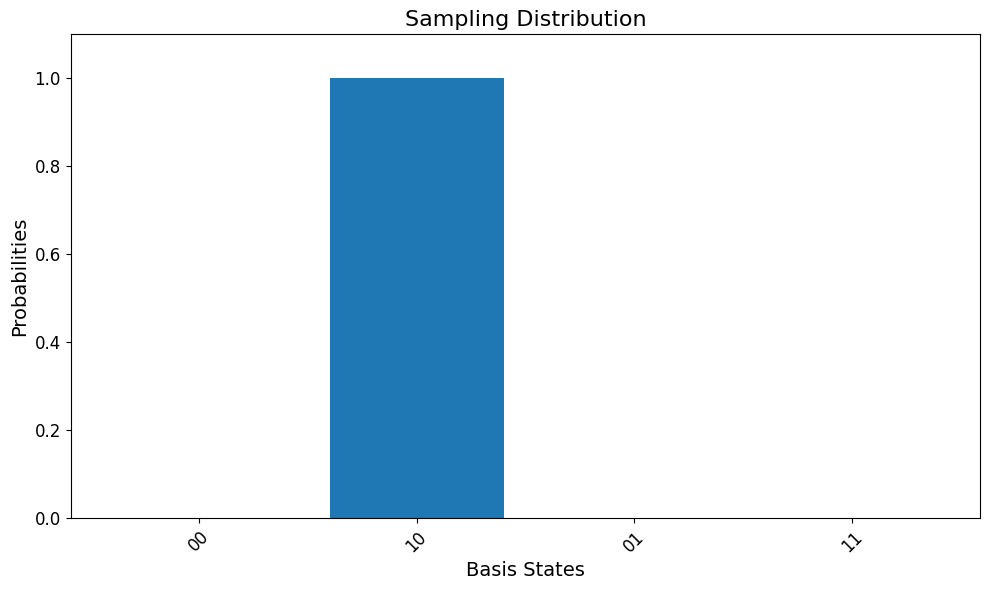

In [160]:
qc = QuantumCircuit(2)
print(qc.state)
qc.X(0)
qc.run(True)
print(qc.state)
print(qc.runtime)
print(qc.sample())
qc.plot_distribution()

In [161]:
qc = QuantumCircuit(8)
print(qc.state)
qc.X(0)
qc.run()
print(qc.state)
print(qc.runtime)

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]


In [162]:
qc = QuantumCircuit(2)
print(qc.state)
qc.X(0)
qc.X(0)
qc.run(True)
print(qc.state)
print(qc.log_states[1])
print(qc.runtime)

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
[[0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]]
3.528594970703125e-05


In [163]:
qc = QuantumCircuit(2)
print(qc.state)
qc.X(1)
qc.CX(0,1)
qc.run(True)
print(qc.log_states[1])
print(qc.state)
print(qc.runtime)

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
[[0.+0.j]
 [0.+0.j]
 [1.+0.j]
 [0.+0.j]]
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [1.+0.j]]
3.24249267578125e-05


## Tensor based circuit simulator class `QuantumCircuit_T`

In [151]:
class QuantumCircuit_T:
      def __init__(self, num_qubits):   # Construct a circuit with initial state |0...0>
         # number of qubits
         self.num_qubits = num_qubits
         # Create a tensor with shape (2,2,....,2) representing State Vector |0...0> with all elements being 0 except the one at index(0,0,....,0) being 1, i.e. [1,0,0,0,0,....]
         # Each axis represents one qubit
         self.state_tensor = np.zeros((2,)*num_qubits, dtype = complex)  # State tensor
         self.state_tensor[(0,)*num_qubits] = 1  # Initialize to |0...0>
         self.state = self.state_tensor.reshape(-1,1)  # State vector
         self.gates = []  # Initialize list of gates along time axis
         self.runtime = 0 # Store rucntime for the circuit simulation
         self.log_states = [] # Store intermediate states for logging

      def QuantumGate(self, unitary, qubit_index, c_qubit1_index = None, c_qubit2_index = None,):
          """
          Wrapper to apply a quantum gate.
          Args:
             unitary: The 2x2 unitary gate to be applied on the target qubit.
             qubit_index (int): The qubit index the gate acts on.
             c_qubit1_index (int): For control qubit gates (e.g.: CX), the index of the control qubit. Set to None by default.
             c_qubit2_index (int): For control qubit gates (e.g.: CCX), the index of the target qubit. Set to None by default.
          """
          if c_qubit1_index is None:  # Single qubit gate
             unitary_matrix = np.array(unitary, dtype=complex)  # Create np.matrix instance for the unitary
             unitary_tensor = unitary_matrix.reshape([2]*2)  # Reshape into a tensor of shape (2,2)
             control_qubit_indices = () # Empty since it is a single qubit gate
             # Add the gate to the circuit
             self.gates.append([unitary_tensor, qubit_index, control_qubit_indices])

          else:
             if c_qubit2_index is None:
                self.control_gate(unitary, qubit_index, c_qubit1_index)
             else:
                self.control_gate(unitary, qubit_index, c_qubit1_index, c_qubit2_index)

      def H(self,  qubit_index):
          """
          Apply a Hadamard gate to a qubit.
          """
          return self.QuantumGate((1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]]),  qubit_index)

      def X(self, qubit_index):
          """
          Apply an X gate to a qubit.
          """
          self.QuantumGate([[0, 1], [1, 0]], qubit_index)

      def Y(self,  qubit_index):
          """
          Apply a Y gate to a qubit.
          """
          return self.QuantumGate([[0, -1j], [1j, 0]],  qubit_index)

      def Z(self, qubit_index):
          """
          Apply a Z gate to a qubit.
          """
          return self.QuantumGate([[1, 0], [0, -1]], qubit_index)

      def CX(self,  qubit_index, c_qubit1_index):
          """
          Apply a CX gate to a qubit.
          """
          return self.QuantumGate([[0, 1], [1, 0]], qubit_index, c_qubit1_index)

      def CCX(self,  qubit_index, c_qubit1_index, c_qubit2_index):
          """
          Apply a CCX gate to a qubit.
          """
          return self.QuantumGate([[0, 1], [1, 0]], qubit_index, c_qubit1_index, c_qubit2_index)

      def control_gate(self, unitary, target_qubit_index, *control_qubit_indices):
          """
          Applies a controlled gate to the circuit.
          unitary: The 2x2 unitary gate to be applied on the target qubit.
          target_qubit_index (int): The index of the target qubit.
          *control_qubit_indices (int): The indices of the control qubits.
          """
          if len(control_qubit_indices) == 0:
            raise ValueError("At least one control qubit is required for a controlled gate.")

          # Initialise a |1><1| projector
          P = np.matrix([[0, 0], [0, 1]], dtype=complex)

         # print(control_qubit_indices)
          one_case_projector = P
          for control_index in control_qubit_indices[1:]:
              one_case_projector = np.kron(one_case_projector, P)
         # print(one_case_projector)
          unitary_matrix = np.matrix(unitary, dtype=complex)  # Create np.matrix instance for the unitary
          one_case_operator = np.kron(one_case_projector, unitary_matrix)  # Tensor product for |1><1| case
         # print(one_case_operator)

          # Define single-qubit identity gate (2x2 identity matrix)
          I = np.eye(2, dtype = complex)
          zero_case_projector = I - P
          for control_index in control_qubit_indices[1:]:
              zero_case_projector = np.kron(zero_case_projector, (I - P))
         # print(zero_case_projector)

          zero_case_operator = np.kron(zero_case_projector, I)  # Tensor product for |0><0| case

          complete_gate =  one_case_operator + zero_case_operator
         #print(complete_gate)
          complete_gate = np.asarray(complete_gate)
          control_gate_tensor = complete_gate.reshape([2]*(2*(len(control_qubit_indices) + 1)))  # Reshape into a tensor

          # Add the gate to the circuit
          self.gates.append([control_gate_tensor, target_qubit_index, control_qubit_indices])


      def run(self, time_log = False):

           #start_time = time.time()
           for gate in self.gates:
               qubit_indices = gate[2] + (gate[1],)
               start_time = time.time()
               # Perform Tensor contraction between the input axes of gate and the control and target qubit axes of the state tensor
               final_state = np.tensordot(gate[0], self.state_tensor, axes=([i for i in range(gate[0].ndim // 2, gate[0].ndim)], [j for j in qubit_indices]))  # Transform the state by doing elementwise matrix multiplication
               self.runtime += time.time() - start_time
               if time_log == True:  # If True, logs the intermediate transformed states
                  self.log_states.append(self.state.copy())


               # Realigning the axes (Permuting) to make the axes represent the qubits in the same order
               num_qubits = self.state_tensor.ndim
               qubit_order = list(range(num_qubits))
               perm = sorted(qubit_order, key=lambda x: qubit_indices.index(x) if x in qubit_indices else float('inf'))

               # Transformed State Tensor after contraction followed by permutation
               self.state_tensor = np.transpose(final_state, axes=perm)
               self.state = self.state_tensor.reshape(-1,1, order='F')

          # self.runtime = time.time() - start_time
           return self.state

      def sample(self):
          sampling = {} # Dictionary to store the probabilities associated with the basis states
          norm = np.linalg.norm(self.state)  # Get the norm of the state
          normalized_state = self.state / norm # Normalize the state vector
          for i in range(2**(self.num_qubits)):
              binary_str = bin(i)[2:] # Convert the integer to binary and remove the "0b" prefix
              binary_str = binary_str.zfill(self.num_qubits) # Pad the binary string with leading zeros to make its length equal to n
              basis = binary_str[::-1] # # Reverse the binary string to match the left-ordered format (LSB on the left)
              P_i = np.abs(normalized_state[i, 0])**2  # Squared absolute value of the resprective amplitude for the probability
              sampling[basis] = P_i  # Squared absolute value of the resprective amplitude for the probability

          return(sampling)

      def plot_distribution(self):
          sampling = self.sample()
          basis_states = list(sampling.keys())
          probabilities = list(sampling.values())

          plt.figure(figsize=(10, 6))
          plt.bar(basis_states, probabilities)

          # Labels and title
          plt.xlabel('Basis States', fontsize=14)
          plt.ylabel('Probabilities', fontsize=14)
          plt.title('Sampling Distribution', fontsize=16)
          plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better readability
          plt.yticks(fontsize=12)
          plt.ylim(0, 1.1)  # The y-axis covers probabilities up to 1.1 to provide extra space

          plt.tight_layout()
          plt.show()

      def expValue(self, observable):
          """
          To compute the expectation value w.r.t. any observable

          Args:
             observable: Any hermitian operator
          Retuns:
             Expectation value (Real) of the observable
          """
          norm = np.linalg.norm(self.state)  # Get the norm of the state
          if norm == 0:
             raise ValueError("The norm of the quantum state is 0, cannot extract any information.")
          normalized_state = self.state / norm # Normalize the state vector
          # Compute expectation value'
          observable = np.array(observable)
          W = (observable @ normalized_state)  # Equals `Op|Ψ>`
          conj_transpose_normalized_state = normalized_state.conj().T # Equals `<Ψ|`
          exp_value = conj_transpose_normalized_state @ W # Equals `<Ψ|Op|Ψ>`

          return exp_value.real[0,0]


### Running different circuits using `QuantumCircuit_T`

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
[[0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]]
2.5987625122070312e-05
{'00': 0.0, '10': 1.0, '01': 0.0, '11': 0.0}


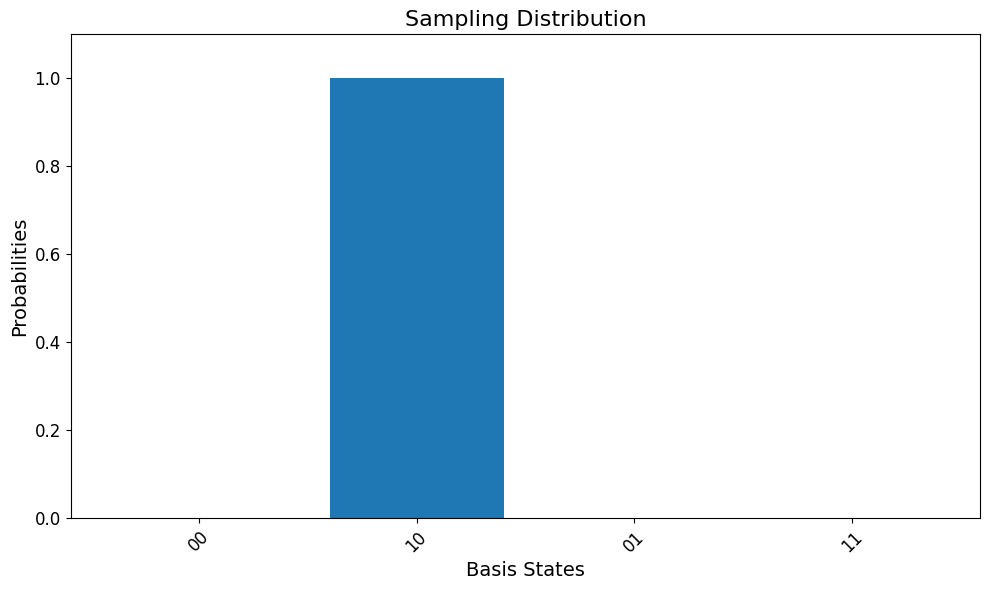

In [165]:
qc = QuantumCircuit(2)
print(qc.state)
qc.X(0)
qc.run(True)
print(qc.state)
print(qc.runtime)
print(qc.sample())
qc.plot_distribution()

In [166]:
qc = QuantumCircuit_T(8)
print(qc.state)
qc.X(0)
qc.run()
print(qc.state)
print(qc.runtime)

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]


In [167]:
qc = QuantumCircuit_T(2)
print(qc.state)
qc.X(0)
qc.X(0)
qc.run(True)
print(qc.state)
print(qc.log_states[1])
print(qc.runtime)

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
[[0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]]
0.00011491775512695312


In [168]:
qc = QuantumCircuit_T(2)
print(qc.state)
qc.X(1)
qc.CX(0,1)
qc.run(True)
print(qc.log_states[1])
print(qc.state)
print(qc.runtime)

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
[[0.+0.j]
 [0.+0.j]
 [1.+0.j]
 [0.+0.j]]
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [1.+0.j]]
0.00012445449829101562


## Comparing `Quantum_Circuit` vs `Quantum_Circuit_T`

### Circuits to run with `QuantumCircuit` and `Quantum_Circuit_T` with varying number of qubits

In [55]:
# Function to run the circuit with a specific range of qubits using QuantumCircuit
def circuit(min, max):
    run_time = []
    for n in range(min, max + 1):
        qc = QuantumCircuit(n)
        qc.H(0)
        qc.X(1)
        qc.CX(0, 1)
        qc.run()
        run_time.append(qc.runtime)

    return run_time

# Function to run the circuit with a specific range of qubits using QuantumCircuit_T
def circuit_T(min, max):
    run_time_T = []
    for n in range(min, max + 1):
        qc = QuantumCircuit_T(n)
        qc.H(0)
        qc.X(1)
        qc.CX(0, 1)
        qc.run()
        run_time_T.append(qc.runtime)

    return run_time_T


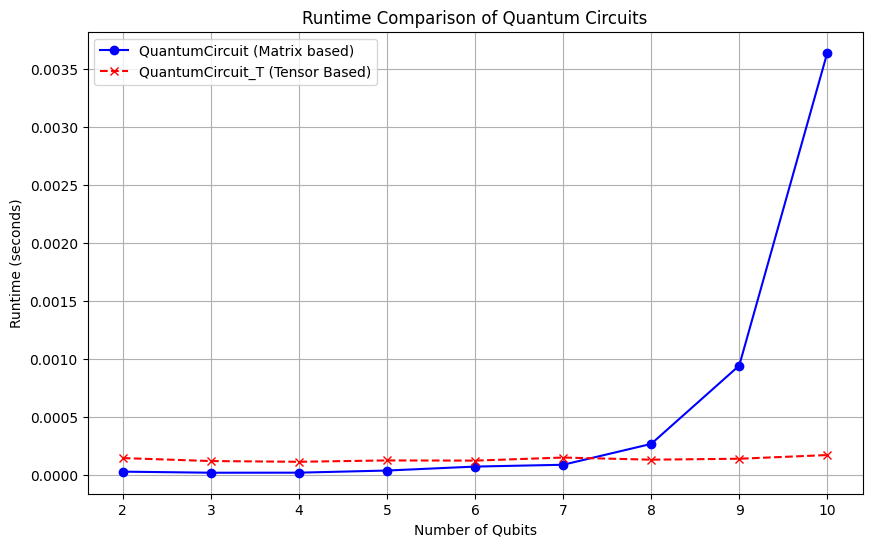

In [56]:
# @title Function to plot the runtimes
min_qubits = 2 # @param {"type":"integer","placeholder":"2"}
max_qubits = 10 # @param {"type":"integer","placeholder":"10"}


# Function to call both circuit functions and plot the results
def plot_runtime(min_qubits, max_qubits):
    # Get runtime data for both circuits
    run_time = circuit(min_qubits, max_qubits)
    run_time_T = circuit_T(min_qubits, max_qubits)

    # Generate qubit numbers for the x-axis
    qubits = list(range(min_qubits, max_qubits + 1))

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(qubits, run_time, label="QuantumCircuit (Matrix based)", marker='o', linestyle='-', color='b')
    plt.plot(qubits, run_time_T, label="QuantumCircuit_T (Tensor Based)", marker='x', linestyle='--', color='r')

    # Adding titles and labels
    plt.title("Runtime Comparison of Quantum Circuits")
    plt.xlabel("Number of Qubits")
    plt.ylabel("Runtime (seconds)")

    # Displaying the legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

# Call the function to plot runtimes for a given range of qubits (e.g., 1 to 10)
plot_runtime(min_qubits, max_qubits)


In tensor contraction, we directly manipulate qubits by accessing specific axes, making it an **O(1)** operation, since we only operate on the relevant dimensions. In contrast, matrix multiplication with increasing qubits involves growing matrices that require more operations, leading to a **O(2^n)** complexity due to the exponential growth of the state space with the number of qubits.

## Creating a ***Bell States*** and computing the ***Expectation values***

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
[[0.70710678+0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.70710678+0.j]]
3.361701965332031e-05
{'00': 0.5000000000000001, '10': 0.0, '01': 0.0, '11': 0.5000000000000001}


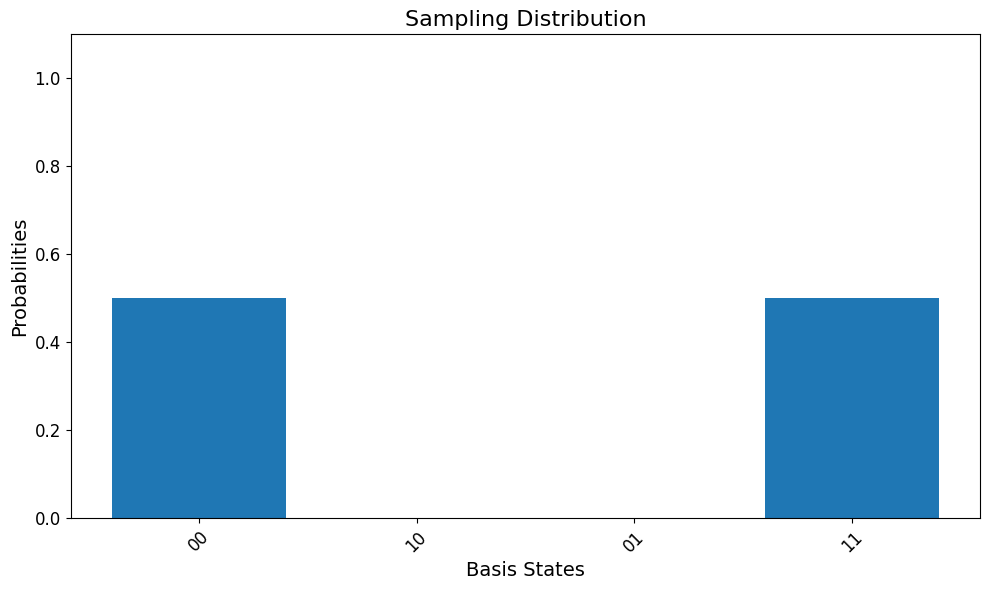

Expection Value w.r.t. ZZ obsevable = 1.0000000000000002


In [152]:
# Bell State 1/sqrt(2) * (|00> + |11>)

qc = QuantumCircuit(2)
print(qc.state)
qc.H(0)
qc.CX(1, 0)
qc.run(True)
print(qc.state)
print(qc.runtime)
print(qc.sample())
qc.plot_distribution()

Z = [[1, 0], [0, -1]]  # Pauli Z matrix, a hermitian operator
ZZ = np.kron(Z, Z) # Creating a ZZ observable
print(f"Expection Value w.r.t. ZZ obsevable = {qc.expValue(ZZ)}")

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
[[ 0.70710678+0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [-0.70710678+0.j]]
4.0531158447265625e-05
{'00': 0.5000000000000001, '10': 0.0, '01': 0.0, '11': 0.5000000000000001}


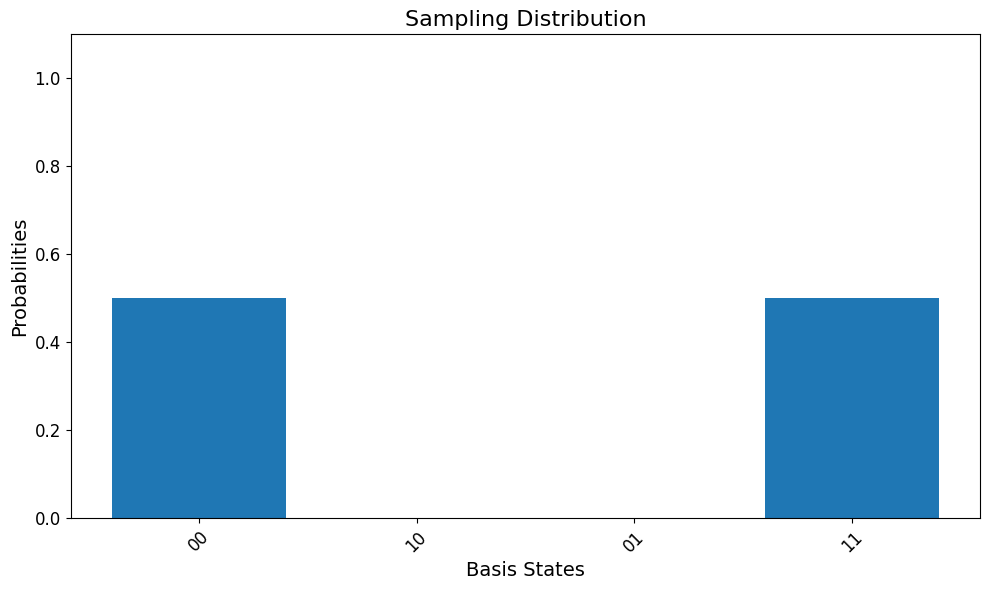

Expection Value w.r.t. ZZ obsevable = 1.0000000000000002


In [155]:
# Bell State 1/sqrt(2) * (|00> - |11>)

qc = QuantumCircuit(2)
print(qc.state)
qc.X(0)
qc.H(0)
qc.CX(1, 0)
qc.run(True)
print(qc.state)
print(qc.runtime)
print(qc.sample())
qc.plot_distribution()

Z = [[1, 0], [0, -1]]  # Pauli Z matrix, a hermitian operator
ZZ = np.kron(Z, Z) # Creating a ZZ observable
print(f"Expection Value w.r.t. ZZ obsevable = {qc.expValue(ZZ)}")

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
[[0.        +0.j]
 [0.70710678+0.j]
 [0.70710678+0.j]
 [0.        +0.j]]
0.0002224445343017578
{'00': 0.0, '10': 0.5000000000000001, '01': 0.5000000000000001, '11': 0.0}


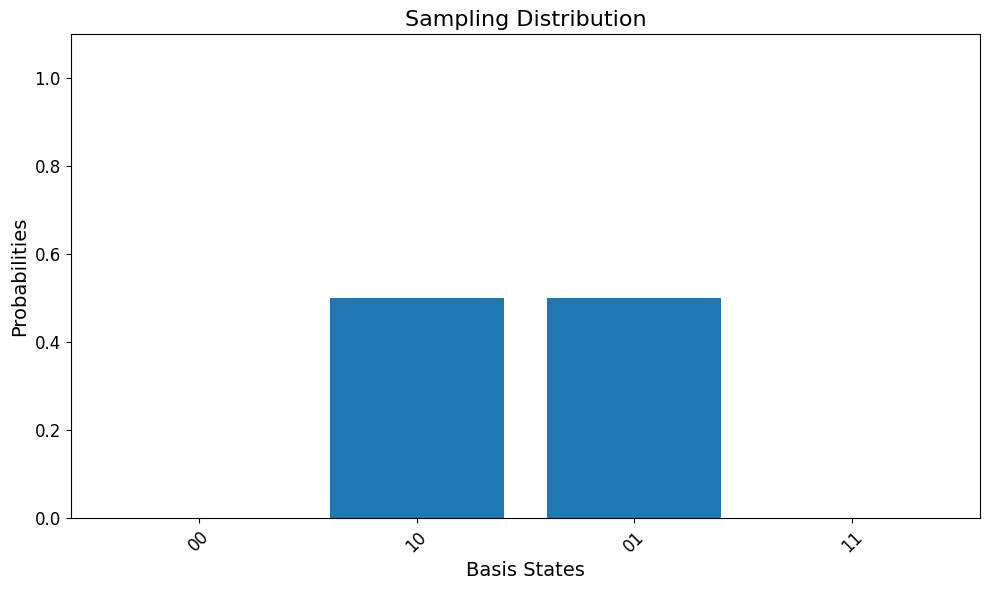

Expection Value w.r.t. ZZ obsevable = -1.0000000000000002


In [158]:
# Bell State 1/sqrt(2) * (|10> + |01>)

qc = QuantumCircuit_T(2)
print(qc.state)
qc.H(0)
qc.X(1)
qc.CX(1, 0)
qc.run(True)
print(qc.state)
print(qc.runtime)
print(qc.sample())
qc.plot_distribution()

Z = [[1, 0], [0, -1]]  # Pauli Z matrix, a hermitian operator
ZZ = np.kron(Z, Z) # Creating a ZZ observable
print(f"Expection Value w.r.t. ZZ obsevable = {qc.expValue(ZZ)}")

[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
[[ 0.        +0.j]
 [ 0.70710678+0.j]
 [-0.70710678+0.j]
 [ 0.        +0.j]]
0.0004134178161621094
{'00': 0.0, '10': 0.5000000000000001, '01': 0.5000000000000001, '11': 0.0}


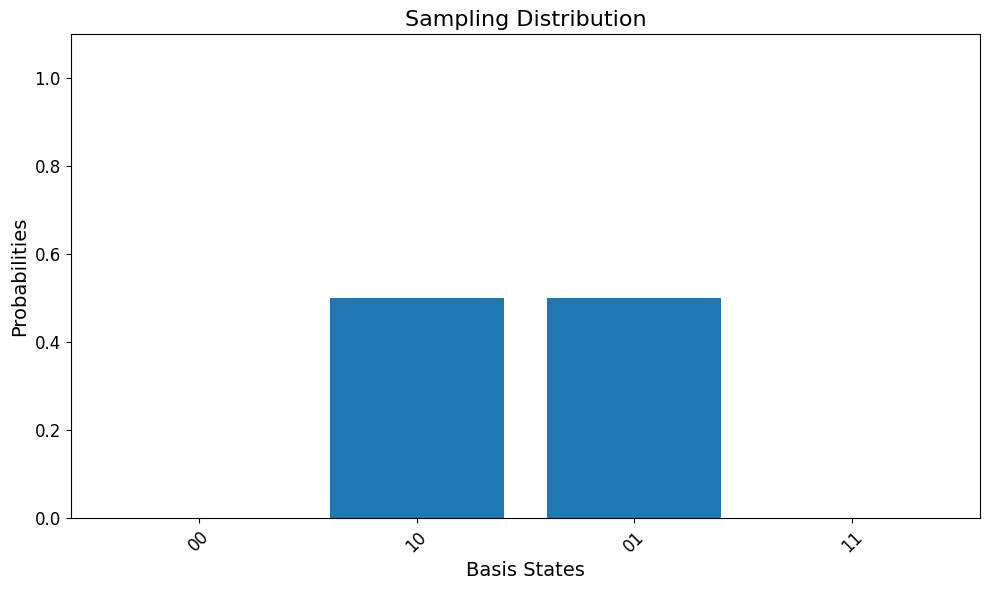

Expection Value w.r.t. ZZ obsevable = -1.0000000000000002


In [159]:
# Bell State 1/sqrt(2) * (|10> - |01>)

qc = QuantumCircuit_T(2)
print(qc.state)
qc.H(0)
qc.X(1)
qc.Z(0)
qc.Z(1)
qc.CX(1, 0)
qc.run(True)
print(qc.state)
print(qc.runtime)
print(qc.sample())
qc.plot_distribution()

Z = [[1, 0], [0, -1]]  # Pauli Z matrix, a hermitian operator
ZZ = np.kron(Z, Z) # Creating a ZZ observable
print(f"Expection Value w.r.t. ZZ obsevable = {qc.expValue(ZZ)}")